In this notebook we want to examine the effects of T1236C, T2677G and T3435C on translation speed. 

- We check their effects on measures correlated with translation speed like MFE, CAI/FPTC and tAI.
- We check whether they are on possible translation bottle necks. 


In [1]:
import pandas as pd
import numpy as np 
from Utils_MDR1 import *
import matplotlib.pyplot as plt
import re
from typing import Union


## Functions

In [32]:
''' 

Plots and saves the MFE profiles of the original and mutated MDR1 CDS in the vicinity of a variant
"cds_pos_1base" - the positions of the mutations, relative to the CDS, 1-based. 
"mfe_positions" - the vector of mfe scores of the entire CDS. Each CDS position has one score. 
"mfe_positions_mutated" - same, but with the variant in "cds_pos_1base". 
"changed_from" - the original nucleotide in "cds_pos_1base"
"changed_to" - the nucleotide that is in "cds_pos_1base" after the variation. 
"pval" - in the notebook "p_vals_mfe.ipynb" we create randomomized sequences (the MDR1 CDS sequence with a single mutation), calculated the delta-mfe for the randomizations 
and obtained an empirical p-value. Here we retrieve it fore the plot. 

'''

def plot_mfe_change(cds_pos_1base: int, mfe_positions: np.array, mfe_positions_mutated: np.array, changed_from: str, changed_to: str, pval: float) -> None:
    
    x = np.arange(mfe_positions.shape[1]) + 1
    plt.plot(x, mfe_positions.T, label = f'{cds_pos_1base}:{changed_from}', c = 'mediumseagreen')
    plt.plot(x, mfe_positions_mutated.T, label = f'{cds_pos_1base}:{changed_to}', c = 'lightcoral')
    delta = np.round((mfe_positions_mutated[0,cds_pos_1base - 1] - mfe_positions[0,cds_pos_1base - 1]),2)

    variant = f"{changed_from}{cds_pos_1base}{changed_to}"
    #plt.title(f"Effect of {variant} on the local MFE profile (delta = {delta}, p = {pval})")
    plt.title(f"{variant} (Delta = {delta}, p = {pval})")

    plt.xlabel("CDS Position")
    plt.ylabel("MFE")
    plt.axvline(x = cds_pos_1base, color = 'royalblue', label = 'position of mutation')
    plt.scatter(cds_pos_1base, mfe_positions.T[cds_pos_1base - 1], c = "mediumseagreen", s = 15 )
    plt.scatter(cds_pos_1base, mfe_positions_mutated.T[cds_pos_1base - 1], c = "lightcoral", s = 15)

    plt.text(cds_pos_1base + 1, mfe_positions_mutated.T[cds_pos_1base - 1] , np.round(mfe_positions_mutated[0,cds_pos_1base - 1],2))
    plt.text(cds_pos_1base - 9, mfe_positions.T[cds_pos_1base - 1], np.round(mfe_positions[0,cds_pos_1base - 1],2))

    plt.legend()
    x_min = cds_pos_1base - 50
    x_max = cds_pos_1base + 50

    plt.xlim([x_min,x_max])
    plt.savefig(f'../Figures/MFE/delta_mfe_{changed_from}{cds_pos_1base}{changed_to}.png', bbox_inches = "tight", dpi=500)

    plt.show()


In [33]:
'''

Calculates the percentiles of the MFE scores of the three variants, compared to all MFE scores of the CDS positions. 
Also, plots the MFE scores of the entire CDS and indicates the location of the three variants.  

''' 
def plot_bottlenecks(positions_of_muts: list, scores: Union[list, np.ndarray], changed_from: str) -> list:
    
    percentiles = []
    
    
    #plot the score profile for the entire CDS
    plt.plot(np.arange(len(scores)), scores, c = 'black')
    
    #emphasize the scores of the variants and add the percentiles to the legend
    for position in positions_of_muts:
        
        score_of_mut = scores[position - 1]
        percentile_of_mut = int(np.round((np.sum(scores < score_of_mut) / len(scores)) * 100))
        percentiles.append(percentile_of_mut)
        plt.scatter(x = position - 1, y = scores[position - 1], label = f'{position}:{changed_from} (%ile {percentile_of_mut})')
        
    plt.legend()
    plt.ylabel("MFE")
    plt.xlabel("CDS Position")
    plt.savefig(f'../Figures/MFE/bottlenecks.png', bbox_inches = "tight", dpi=500)

    
    return(percentiles)

In [34]:
''' 

Returns a list of CAI scores that is respective of a given sequence.
nt_CDS is the sequence, in nucleotides.
cai_dict is a dictionary where the keys are codons and the values are the CAI weights. 

'''

def get_cai_of_sequence(nt_CDS: str, cai_dict: dict) -> list: 
    cai_of_seq = []
    for index in range(0,len(nt_CDS),3):
        codon = nt_CDS[index:index+3]
        cai_val = cai_dict[codon]
        cai_of_seq.append(cai_val)
    return(cai_of_seq)

In [35]:
''' 

Returns a list of FPTC (frequency per thousand codons) scores that is respective of a given sequence.
nt_CDS is the sequence, in nucleotides.
fptc_dict is a dictionary where the keys are codons and the values are the fptc weights. 

'''

def get_fptc_of_sequence(nt_CDS: str, fptc_dict: dict) -> list:
    
    fptc_of_seq = []
    for index in range(0,len(nt_CDS),3):
        codon = nt_CDS[index:index+3]
        freq1000_val = fptc_dict[codon]
        fptc_of_seq.append(freq1000_val)
    return(fptc_of_seq)   

In [36]:
''' 

Returns a list of tAI scores that is respective of a given sequence.
nt_CDS is the sequence, in nucleotides.
tai_dict is a dictionary where the keys are codons and the values are the tAI weights. 

'''

def get_tai_of_sequence(nt_CDS: str, tai_dict: dict) -> list:
    tai_of_seq = []
    for index in range(0,len(nt_CDS),3):
        codon = nt_CDS[index:index+3]
        tai_val = tai_dict[codon]
        tai_of_seq.append(tai_val)
    return(tai_of_seq)

In [37]:
'''

Plots and saves the CAI/FPTC/tAI profiles of the original and the mutated MDR1 CDS in the vicinity of a variant.
"variant" - the name of the variant, for example "T1236C".
"measure" - either CAI, FPTC, tAI
"len_aa" - the length of the protein
"scores_of_cds" - a vector with the scores of the entire CDS (a single score for each aa/codon) 
"measure_dict" - keys are codons, values are the scores of the codons, which depend on the measure
"aa_position" - protein position of the variant (1-based)
"cds_position" - cds position of the variant (1-based)
"tissue" - tAI is tissue specific, we have a different measure_dict for each tissue. 

'''

def plot_cub_change(variant: str, measure: str, len_aa: int, scores_of_cds: list, measure_dict: dict, aa_position: int, cds_position: int,
                    codon_before: str, codon_after: str, change_from: str, change_to: str, pval: float, tissue: str = None, tissues_titles_dict = None) -> None:
    
    plt.figure()
    plt.scatter(np.arange(1, len_aa + 1), scores_of_cds, c = 'black', label = 'surroundings')
    plt.axvline(x = aa_position, color = 'royalblue', label = 'position of variant')

    plt.scatter(aa_position, measure_dict[codon_before], label = f'{cds_position}:{change_from} (codon: {codon_before})', c = "mediumseagreen")
    plt.scatter(aa_position, measure_dict[codon_after], label = f'{cds_position}:{change_to} (codon: {codon_after})', c = "lightcoral")

    plt.text(aa_position + 0.15, measure_dict[codon_before] , np.round(measure_dict[codon_before],2))
    plt.text(aa_position + 0.15, measure_dict[codon_after] , np.round(measure_dict[codon_after],2))

    plt.xlim([aa_position - 7, aa_position + 7])
    plt.legend()

    delta = np.round(measure_dict[codon_after] - measure_dict[codon_before], 2)

    # title_tai = f"Effect of {change_from}{cds_position}{change_to} on the local {measure} profile in the {tissue} (delta = {delta} , p = {pval})"
    # title_else = f"Effect of {change_from}{cds_position}{change_to} on the local {measure} profile (delta = {delta} , p = {pval})"
    if tissues_titles_dict:
        title = f"{change_from}{cds_position}{change_to}, {tissues_titles_dict[tissue]} (Delta = {delta} , p = {pval})"
    else:
        title = f"{change_from}{cds_position}{change_to} (Delta = {delta} , p = {pval})"
    plt.title(title)

    plt.xlabel("Protein Position")
    plt.ylabel(measure)
    
    save_path = f'../Figures/{measure}/{variant}_delta_{measure}_{tissues_titles_dict[tissue]}.png'if tissue else f'../Figures/{measure}/{variant}_delta_{measure}.png'
    plt.savefig(save_path, bbox_inches = "tight", dpi=500)


In [38]:
''' 

Given the scores of all CDS positions for a specific measure (CAI, tAI, etc.) calculate the percentile of a variant. 
For example, if all scores are [1,2,3,4,5,6,7,8,9,10] and the score of the variant is 5 then the variant is in the 40% percentile. 

'''

def get_percentile(score_pos:float, all_scores:list) -> int:
    percentile_of_position = (np.sum(np.array(all_scores) < score_pos) / len(all_scores)) * 100
    return(int(np.round(percentile_of_position)))

    

## Main

In [39]:
''' Get the MDR1 sequence '''
gene = "ENSG00000085563" #MDR1
genes_dict = pd.read_pickle(f"../Data/cdna_{gene}.pickle.gz")
nt_CDS = genes_dict['data'][0]['homologies'][0]['source']['seq'][:-3] #removing stop codon -> msa was on aas and ttanslated back, so no info on stop codons

''' Get/define variables needed for measures calculations (CAI, FPTC, tAI...), not sprecific to any variant '''
#CAI
codon_usage_dict = pd.read_pickle("../Data/homo_sapiens_CAI.pickle") # get human CAI weights
cai_of_cds = get_cai_of_sequence(nt_CDS, codon_usage_dict) #calculate the CAI weights for the complete MDR1 CDS
len_aa = len(cai_of_cds) #length of the *protein*
#tAI
tai_tissues = pd.read_pickle("../Data/tAI_human_tissue_specific.pickle")# get human tAI weights- this is a nested dictionary, tAI changes dramatically among tissues
tissues_mdr1 = ["KIRC", "LIHC", "GBM_", "COAD"] #tissues in organs where MDR1 is naturally highly expressed
#FPTC - frequency per thousand codons
codon_usage_csv = pd.read_csv("../Data/Human_codon_frequency.txt", skiprows = 5, header = None) # get human FPTC weights
codons_and_freq1000 =  codon_usage_csv[0].apply(lambda x: get_codon_and_freq(x))
dict_freq1000 = dict((codon.replace("U","T"), float(freq)) for codon, freq in codons_and_freq1000)


### T1236C

In [40]:
''' Variant info '''

variant_name = variant_info[1]["variant_name"]
aa_position = variant_info[1]["aa_position"]
cds_position = variant_info[1]["cds_position"]
codon_before = variant_info[1]["codon_before"]
codon_after = variant_info[1]["codon_after"]
change_from = variant_info[1]["change_from"]
change_to = variant_info[1]["change_to"]


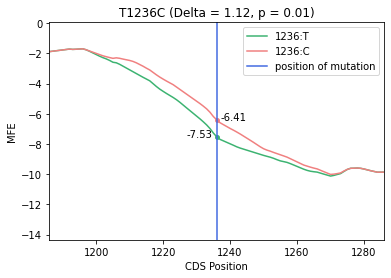

In [41]:
''' mfe '''
measure = "mfe"

#get mfe profile of the original sequence
mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

#get mfe profile of the mutated sequence
nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position

#we also calculated a p-value in the notebook "p_vals_mfe.ipynb"
pvalue = pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{change_from}{cds_position}{change_to}.pickle")

#plot both
plot_mfe_change(cds_position, mfe_positions, mfe_positions_mut, change_from, change_to, np.round(pvalue,2))


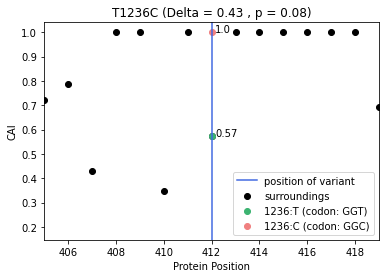

In [42]:
''' CAI '''
measure = "CAI"
pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{cds_position}.pickle"),2)

plot_cub_change(variant_name, measure, len_aa, cai_of_cds, codon_usage_dict, aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval)


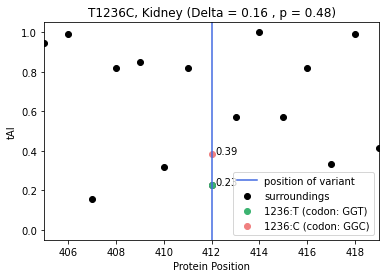

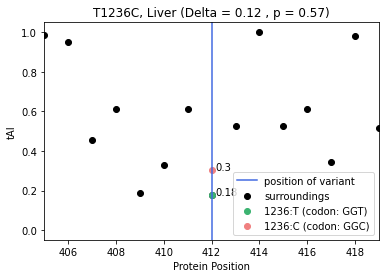

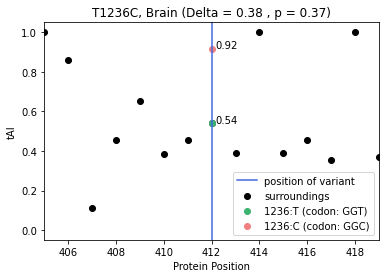

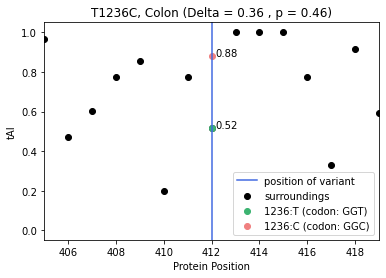

In [43]:
''' tAI '''
measure = "tAI"

for tissue in tissues_mdr1:
    tai_of_cds= get_tai_of_sequence(nt_CDS, tai_tissues[tissue])
    pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/{tissue}/pval_{cds_position}.pickle"),2)
    plot_cub_change(variant_name, measure, len_aa, tai_of_cds, tai_tissues[tissue], aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval, tissue, tissues_titles_dict)
    

### T3435C

In [44]:
''' Variant info '''

variant_name = variant_info[3]["variant_name"]
aa_position = variant_info[3]["aa_position"]
cds_position = variant_info[3]["cds_position"]
codon_before = variant_info[3]["codon_before"]
codon_after = variant_info[3]["codon_after"]
change_from = variant_info[3]["change_from"]
change_to = variant_info[3]["change_to"]


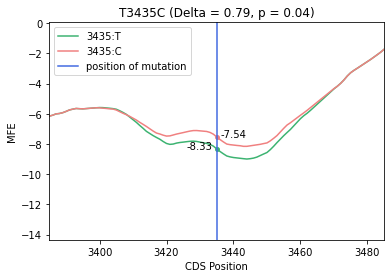

In [45]:
''' mfe '''
measure = "mfe"

#get mfe profile of the original sequence
mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

#get mfe profile of the mutated sequence
nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position

#we also calculated a p-value in the notebook "p_vals_mfe.ipynb"
pvalue = pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{change_from}{cds_position}{change_to}.pickle")

#plot both
plot_mfe_change(cds_position, mfe_positions, mfe_positions_mut, change_from, change_to, np.round(pvalue,2))


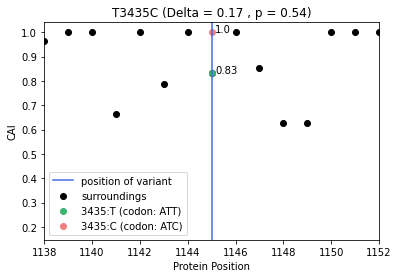

In [46]:
''' CAI '''
measure = "CAI"
pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{cds_position}.pickle"),2)

plot_cub_change(variant_name, measure, len_aa, cai_of_cds, codon_usage_dict, aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval)


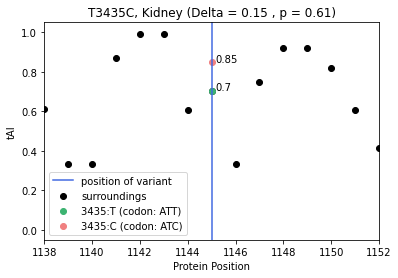

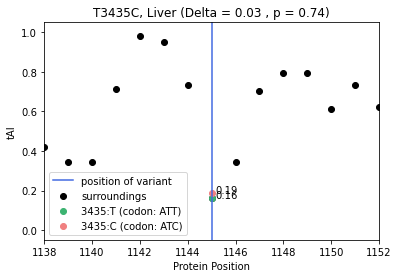

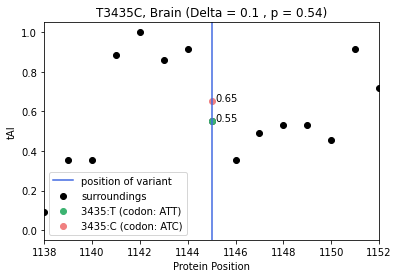

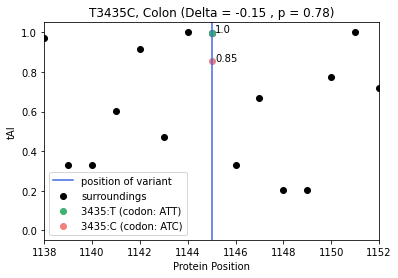

In [47]:
''' tAI '''
measure = "tAI"

for tissue in tissues_mdr1:
    tai_of_cds= get_tai_of_sequence(nt_CDS, tai_tissues[tissue])
    pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/{tissue}/pval_{cds_position}.pickle"),2)
    plot_cub_change(variant_name, measure, len_aa, tai_of_cds, tai_tissues[tissue], aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval, tissue, tissues_titles_dict)
    

### T2677G

In [48]:
''' Variant info '''

variant_name = variant_info[2]["variant_name"]
aa_position = variant_info[2]["aa_position"]
cds_position = variant_info[2]["cds_position"]
codon_before = variant_info[2]["codon_before"]
codon_after = variant_info[2]["codon_after"]
change_from = variant_info[2]["change_from"]
change_to = variant_info[2]["change_to"]


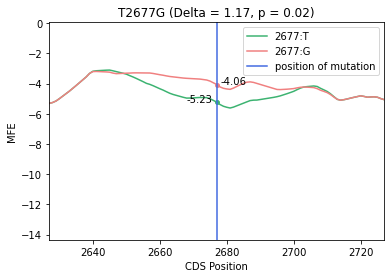

In [49]:
''' mfe '''
measure = "mfe"

#get mfe profile of the original sequence
mfe_windows = calc_windows_mfe(nt_CDS, 39) #calculate mfe per window
mfe_positions = calc_mfe_per_position(mfe_windows, 'original', 38, 39) #change to mfe per position

#get mfe profile of the mutated sequence
nt_CDS_mut = mutate_cds_sequence(nt_CDS, cds_position, change_to) #mutate the sequence
mfe_windows_mut = calc_windows_mfe(nt_CDS_mut, 39) #calculate mfe per window
mfe_positions_mut = calc_mfe_per_position(mfe_windows_mut, 'original', 38, 39) #change to mfe per position

#we also calculated a p-value in the notebook "p_vals_mfe.ipynb"
pvalue = pd.read_pickle(f"../Results/{measure}/delta_{measure}/pval_{change_from}{cds_position}{change_to}.pickle")

#plot both
plot_mfe_change(cds_position, mfe_positions, mfe_positions_mut, change_from, change_to, np.round(pvalue,2))


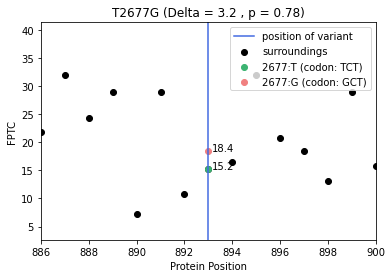

In [50]:
''' FPTC '''
measure = "FPTC"

fptc_of_cds = get_fptc_of_sequence(nt_CDS, dict_freq1000)
plot_cub_change(variant_name, measure, len_aa, fptc_of_cds, dict_freq1000, aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval)


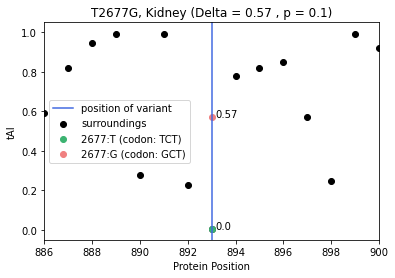

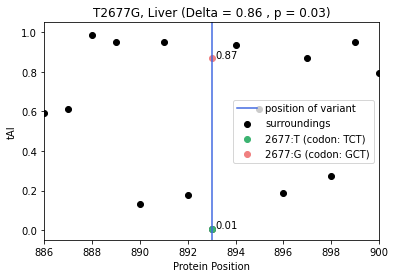

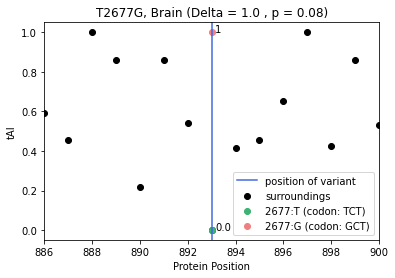

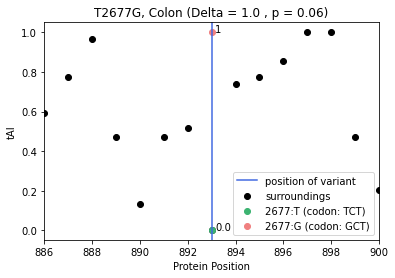

In [51]:
''' tAI '''
measure = "tAI"

for tissue in tissues_mdr1:
    tai_of_cds= get_tai_of_sequence(nt_CDS, tai_tissues[tissue])
    pval = np.round(pd.read_pickle(f"../Results/{measure}/delta_{measure}/{tissue}/pval_{cds_position}.pickle"),2)
    plot_cub_change(variant_name, measure, len_aa, tai_of_cds, tai_tissues[tissue], aa_position, cds_position, codon_before, codon_after, change_from, change_to, pval, tissue, tissues_titles_dict)
    

## Are these variants in translational bottlenecks?

The mfe, CAI, tAI percentiles of the position of variant T1236C are :19,16,[12, 11, 39, 29]
The mfe, CAI, tAI percentiles of the position of variant T3435C are :19,43,[51, 7, 41, 79]
The mfe, CAI, tAI percentiles of the position of variant T2677G are :19,43,[2, 5, 2, 1]


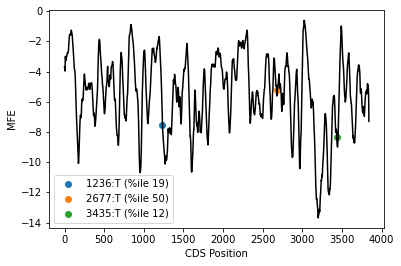

In [52]:
cds_positions = [variant_info[1]["cds_position"],variant_info[2]["cds_position"],variant_info[3]["cds_position"]]
aa_positions = [variant_info[1]["aa_position"],variant_info[2]["aa_position"],variant_info[3]["aa_position"]]

''' mfe '''
mfe_positions = mfe_positions.reshape(mfe_positions.shape[1])
percentiles = plot_bottlenecks(cds_positions, mfe_positions, "T")

''' CUB '''
#T1236C
perc_cai = get_percentile(cai_of_cds[variant_info[1]["aa_position"] - 1], cai_of_cds)
perc_tai_tissues = []
for tissue in tissues_mdr1:
    tai_of_cds= get_tai_of_sequence(nt_CDS, tai_tissues[tissue])
    perc_tai = get_percentile(tai_of_cds[variant_info[1]["aa_position"] - 1], tai_of_cds)
    perc_tai_tissues.append(perc_tai)
variant_name = variant_info[1]["variant_name"]
print(f"The mfe, CAI, tAI percentiles of the position of variant {variant_name} are :{percentiles[0]},{perc_cai},{perc_tai_tissues}")


#T3435C
perc_cai = get_percentile(cai_of_cds[variant_info[3]["aa_position"] - 1], cai_of_cds)
perc_tai_tissues = []
for tissue in tissues_mdr1:
    tai_of_cds= get_tai_of_sequence(nt_CDS, tai_tissues[tissue])
    perc_tai = get_percentile(tai_of_cds[variant_info[3]["aa_position"] - 1], tai_of_cds)
    perc_tai_tissues.append(perc_tai)
variant_name = variant_info[3]["variant_name"]
print(f"The mfe, CAI, tAI percentiles of the position of variant {variant_name} are :{percentiles[0]},{perc_cai},{perc_tai_tissues}")

#T2677G
perc_fptc = get_percentile(fptc_of_cds[variant_info[2]["aa_position"] - 1], fptc_of_cds)
perc_tai_tissues = []
for tissue in tissues_mdr1:
    tai_of_cds= get_tai_of_sequence(nt_CDS, tai_tissues[tissue])
    perc_tai = get_percentile(tai_of_cds[variant_info[2]["aa_position"] - 1], tai_of_cds)
    perc_tai_tissues.append(perc_tai)
variant_name = variant_info[2]["variant_name"]
print(f"The mfe, CAI, tAI percentiles of the position of variant {variant_name} are :{percentiles[0]},{perc_cai},{perc_tai_tissues}")
